In [4]:
## COMBINE P-VALUES ##

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

def fisher_method_log10(pvalues):
    df = 2 * len(pvalues)
    return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))

In [6]:
# File paths
relate_LWK = "/home/ari/ari-intern/people/ari/ariadna-intern/steps/LWK/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele"
kasper_LWK = "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_LWK_runstats.h5"

# Read files into DataFrames
file1 = pd.read_csv(relate_LWK, sep=' ')
file2 = pd.read_hdf(kasper_LWK)

# Convert 'pos' column to integers in the second DataFrame
file2['pos'] = file2['pos'].astype(int)

# Merge the two DataFrames on the 'pos' column
merged_df = pd.merge(file1[['pos', 'when_mutation_has_freq2']], file2[['pos', 'p']], on='pos', how='inner')

# Apply -np.log10() function to the 'p' column (K p-value is not under logarithm)
merged_df['p'] = -np.log10(merged_df['p'])

# Change negative values to positive in the second and last columns
merged_df[['when_mutation_has_freq2', 'p']] = merged_df[['when_mutation_has_freq2', 'p']].abs()

# Output the merged DataFrame
print(merged_df.head())

       pos  when_mutation_has_freq2         p
0  2781642                 0.082692  0.000000
1  2781865                 0.489434  0.257507
2  2781927                 1.083170  0.011587
3  2782572                 0.145357  0.446430
4  2783658                 0.610668  0.000000


In [7]:
combined_values = merged_df[['when_mutation_has_freq2', 'p']].values.tolist() # list of pairs

# Slice the combined_values list to get the first 10 pairs
first_10_pairs = combined_values[:10]

# Print the first 10 pairs
for pair in first_10_pairs:
    print(pair)

[0.0826921, 0.0]
[0.489434, 0.25750726103044325]
[1.08317, 0.01158723504246924]
[0.145357, 0.4464296957937116]
[0.610668, 0.0]
[0.669481, 0.07980614472854675]
[1.51888, 0.05019178300642131]
[2.42716, 0.06522837062653015]
[0.927731, 0.06796626245089575]
[0.473929, 0.22169985569454498]


In [8]:
# Convert data to DataFrame
df = pd.DataFrame(merged_df)

# Define fisher_method_log10 function
def fisher_method_log10(pvalues):
    df = 2 * len(pvalues)
    return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))

# Combine p-values
combined_p_values = df[['when_mutation_has_freq2', 'p']].apply(fisher_method_log10, axis=1)

# Create a new DataFrame with pos and combined p-values
new_df = pd.DataFrame({'pos': df['pos'], 'combined_p_values': combined_p_values})

# Output the new DataFrame
print(new_df)

/scratch/37891617/ipykernel_3165351/2552376622.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))
/scratch/37891617/ipykernel_3165351/2552376622.py:7: RuntimeWarning: divide by zero encountered in log10
  return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))


            pos  combined_p_values
0       2781642                inf
1       2781865           0.412206
2       2781927           1.170706
3       2782572           0.615516
4       2783658                inf
...         ...                ...
82893  35307924                inf
82894  35307966           0.148263
82895  35308281           0.793465
82896  35308851           0.716891
82897  35309375           0.716891

[82898 rows x 2 columns]


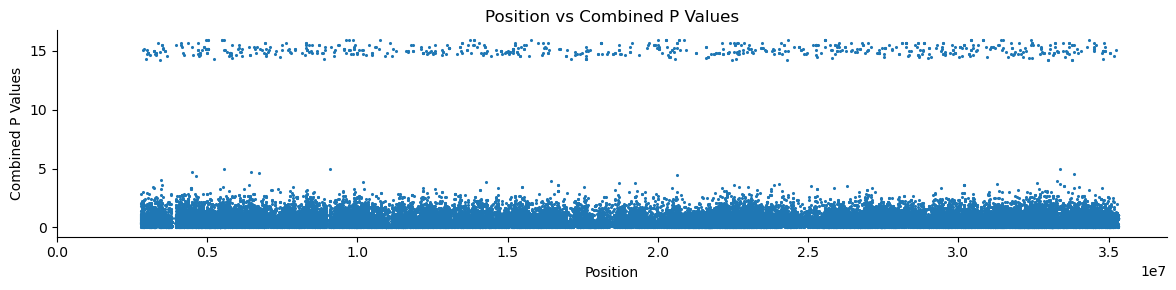

In [13]:
# Plotting
plt.figure(figsize=(12, 3))
sns.scatterplot(data=new_df, x='pos', y='combined_p_values', linewidth=0, s=5)
plt.xticks(np.arange(0, new_df['pos'].max()+1, 5000000))
plt.xlabel('Position')
plt.ylabel('Combined P Values')
plt.title('Position vs Combined P Values')
plt.tight_layout()
sns.despine()
plt.show()